###  Notebook para prototipado para predicción de precios inmobiliarios

#### Para mas información sobre cual es el objetivo, el uso y el analisis de los modelos, consultar el documento cuyo link esta en el readme

#### Ingesta del dataset desde Kaggle, si es necesario y guardado de datos en crudo: 

In [11]:
#si da error  de  kaggle, volver a correr la celda
import duckdb
import os
import pandas as pd
from dotenv import load_dotenv
from kaggle.api.kaggle_api_extended import KaggleApi
from datetime import datetime, timezone
import glob
import re
import json

# --- CONFIGURACIÓN ---
DB_PATH = "app/data/DB/entrenamiento.duckdb"
RAW_DIR = "app/data/artifacts/RAW"
PARQUET_DIR = "app/data/artifacts/parquet"
PARQUET_PATH = os.path.join(PARQUET_DIR, "entrenamiento.parquet")

LEGACY_CSV_PATH = os.path.join(RAW_DIR, "entrenamiento.csv")
KAGGLE_FILE_BASE = "entrenamiento"
VERSIONED_CSV_PATTERN = os.path.join(RAW_DIR, f"{KAGGLE_FILE_BASE}-*.csv")
DATE_FORMAT = "%Y-%m-%d"
KAGGLE_DATASET = "alejandroczernikier/properati-argentina-dataset"
KAGGLE_FILE_NAME = "entrenamiento.csv"

load_dotenv()


#  UTILIDADES 
def ensure_directories():
    os.makedirs(RAW_DIR, exist_ok=True)
    os.makedirs(PARQUET_DIR, exist_ok=True)
    os.makedirs(os.path.dirname(DB_PATH), exist_ok=True)


def find_latest_local_versioned_file(pattern: str, date_format: str):
    # Busca el archivo versionado más reciente según el nombre
    latest_date = None
    latest_file = None
    date_pattern = re.compile(rf"{KAGGLE_FILE_BASE}-(\d{{4}}-\d{{2}}-\d{{2}})\.csv")

    for filepath in glob.glob(pattern):
        match = date_pattern.search(os.path.basename(filepath))
        if match:
            date_str = match.group(1)
            try:
                file_date = datetime.strptime(date_str, date_format).replace(
                    tzinfo=timezone.utc
                )
                if latest_date is None or file_date > latest_date:
                    latest_date = file_date
                    latest_file = filepath
            except ValueError:
                pass
    return latest_file, latest_date


def get_kaggle_dataset_update_time(dataset_slug: str):
    # fecha de última actualización desde la API de Kaggle
    print(
        "Contactando API de Kaggle para verificar la última actualización del dataset..."
    )
    import requests
    from requests.auth import HTTPBasicAuth

    try:
        api = KaggleApi()
        api.authenticate()

        username = os.getenv("KAGGLE_USERNAME")
        key = os.getenv("KAGGLE_KEY")

        # leer desde kaggle.json si no está en el entorno
        if not username or not key:
            kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")
            if os.path.exists(kaggle_json_path):
                with open(kaggle_json_path, "r") as f:
                    creds = json.load(f)
                    username = creds.get("username")
                    key = creds.get("key")

        if not username or not key:
            raise ValueError(
                "Faltan credenciales KAGGLE_USERNAME o KAGGLE_KEY en el entorno o kaggle.json."
            )

        url = f"https://www.kaggle.com/api/v1/datasets/view/{dataset_slug}"
        response = requests.get(url, auth=HTTPBasicAuth(username, key))
        response.raise_for_status()
        metadata = response.json()

        kaggle_date_str = metadata.get("lastUpdated")
        if kaggle_date_str:
            for fmt in ("%Y-%m-%dT%H:%M:%S.%fZ", "%Y-%m-%dT%H:%M:%SZ"):
                try:
                    kaggle_date = datetime.strptime(kaggle_date_str, fmt).replace(
                        tzinfo=timezone.utc
                    )
                    print(f"Fecha de última actualización en Kaggle: {kaggle_date}")
                    return kaggle_date
                except ValueError:
                    continue
        print("Advertencia: no se pudo interpretar la fecha 'lastUpdated'.")
        return None

    except Exception as e:
        print(f"ERROR: Fallo al contactar la API de Kaggle: {e}")
        return None


def download_from_kaggle_and_rename(
    dataset_slug: str, file_name: str, kaggle_time: datetime, date_format: str
):
    # Descarga el dataset desde Kaggle y lo renombra según la fecha de metadata Kaggle
    date_str = (
        kaggle_time.strftime(date_format)
        if kaggle_time
        else datetime.now().strftime(date_format)
    )
    new_filename = f"{KAGGLE_FILE_BASE}-{date_str}.csv"
    new_filepath = os.path.join(RAW_DIR, new_filename)
    original_download_path = os.path.join(RAW_DIR, file_name)

    print(f"Descargando {file_name} desde Kaggle...")
    try:
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files(dataset_slug, path=RAW_DIR, unzip=True, force=True)

        if not os.path.exists(original_download_path):
            print(
                f"ERROR: No se encontró {original_download_path} después de descargar"
            )
            return None

        if os.path.exists(new_filepath):
            os.remove(new_filepath)
        os.rename(original_download_path, new_filepath)
        print(f"Descarga completa y renombrada a {new_filepath}")
        return new_filepath
    except Exception as e:
        print(f"ERROR: Fallo la descarga de Kaggle: {e}")
        return None


# Carga el CSV en DuckDB y genera un Parquet
def run_duckdb_pipeline(csv_path_to_load: str):

    if not os.path.exists(csv_path_to_load):
        print(f"ERROR: No existe {csv_path_to_load}.")
        return
    print(f"\nConectando a DuckDB en {DB_PATH}...")
    try:
        con = duckdb.connect(DB_PATH)
        con.execute(
            f"""
            CREATE OR REPLACE TABLE datos_raw AS 
            SELECT * FROM read_csv_auto('{csv_path_to_load}')
        """
        )
        print("Tabla 'datos_raw' actualizada.")
        con.execute(
            f"""
            COPY (
                SELECT * FROM datos_raw
            ) TO '{PARQUET_PATH}' (FORMAT PARQUET, OVERWRITE_OR_IGNORE TRUE)
        """
        )
        print(f"parquet generado en {PARQUET_PATH}.")
    finally:
        con.close()


# ingesta
def process_entrenamiento():
    ensure_directories()

    file_to_process = None
    needs_db_update = False

    if os.path.exists(LEGACY_CSV_PATH):
        print(
            f"Se encontró el archivo legacy '{LEGACY_CSV_PATH}'. No es necesario conectar a Kaggle."
        )
        file_to_process = LEGACY_CSV_PATH
        needs_db_update = True
    else:
        print(" Verificando archivos CSV")
        local_filepath, local_date = find_latest_local_versioned_file(
            VERSIONED_CSV_PATTERN, DATE_FORMAT
        )
        kaggle_time = get_kaggle_dataset_update_time(KAGGLE_DATASET)

        if not local_filepath:
            print("No hay archivo local. Descargando desde Kaggle...")
            new_path = download_from_kaggle_and_rename(
                KAGGLE_DATASET, KAGGLE_FILE_NAME, kaggle_time, DATE_FORMAT
            )
            if new_path:
                file_to_process = new_path
                needs_db_update = True
            else:
                print("ERROR: Fallo al descargar desde Kaggle. Exit")
        elif kaggle_time and kaggle_time.date() > local_date.date():
            print(
                f"Kaggle ({kaggle_time.date()}) es más reciente que local ({local_date.date()}). Descargando nueva versión..."
            )
            new_path = download_from_kaggle_and_rename(
                KAGGLE_DATASET, KAGGLE_FILE_NAME, kaggle_time, DATE_FORMAT
            )
            if new_path:
                file_to_process = new_path
                needs_db_update = True
                try:
                    os.remove(local_filepath)
                    print(f"Archivo anterior eliminado: {local_filepath}")
                except OSError as e:
                    print(f"Advertencia: No se pudo eliminar {local_filepath}: {e}")
        else:
            print(
                f"Archivo local ({local_filepath}) está actualizado (Fecha {local_date.date()})."
            )
            file_to_process = local_filepath

    if file_to_process and needs_db_update:
        print("\nActualizando DuckDB y Parquet")
        run_duckdb_pipeline(file_to_process)
        print("\n Proceso completo")
    elif file_to_process:
        print(
            f"\nEl archivo {file_to_process} está actualizado. No se requiere actualización."
        )
    else:
        print("\n No hay archivo CSV disponible.")

In [12]:
process_entrenamiento()

Se encontró el archivo legacy 'app/data/artifacts/RAW\entrenamiento.csv'. No es necesario conectar a Kaggle.

Actualizando DuckDB y Parquet

Conectando a DuckDB en app/data/DB/entrenamiento.duckdb...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Tabla 'datos_raw' actualizada.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

parquet generado en app/data/artifacts/parquet\entrenamiento.parquet.

 Proceso completo


In [13]:
#verificar el guardado de tablas de datos en crudo 
DB_PATH = "app/data/DB/entrenamiento.duckdb"

con = duckdb.connect(DB_PATH)
tables = con.execute("SHOW TABLES").fetchall()
print("Tablas en DuckDB:")
for t in tables:
    print("-", t[0])

Tablas en DuckDB:
- datos_clean
- datos_raw
- metricas


### Estudio del dataset

In [14]:
# cant. de filas
n_filas = duckdb.query(
    "SELECT COUNT(*) FROM 'app/data/artifacts/parquet/entrenamiento.parquet'"
).fetchone()[0]
print("Filas:", n_filas)

Filas: 992192


In [15]:
# profiling del dataset en parquet
parquet_file = "app/data/artifacts/parquet/entrenamiento.parquet"

con = duckdb.connect()

# Obtener metadatos de columnas
cols = con.execute(
    f"""
DESCRIBE SELECT * FROM parquet_scan('{parquet_file}')
"""
).fetchdf()

profiling_results = []

for _, row in cols.iterrows():
    col = row["column_name"]
    dtype = row["column_type"].lower()

    is_numeric = any(t in dtype for t in ["int", "decimal", "double", "float", "real"])

    stats_query = f"""
    SELECT
        '{col}' AS column,
        '{dtype}' AS dtype,
        COUNT(*) AS total,
        COUNT(*) FILTER (WHERE "{col}" IS NULL) AS nulls,
        COUNT(DISTINCT "{col}") AS distinct_values,
        { "MIN(" + col + ")" if is_numeric else "NULL" } AS min,
        { "MAX(" + col + ")" if is_numeric else "NULL" } AS max,
        { "AVG(" + col + ")" if is_numeric else "NULL" } AS mean,
        { "MEDIAN(" + col + ")" if is_numeric else "NULL" } AS median,
        { "QUANTILE(" + col + ", 0.25)" if is_numeric else "NULL" } AS Q1,
        { "QUANTILE(" + col + ", 0.75)" if is_numeric else "NULL" } AS Q3
    FROM parquet_scan('{parquet_file}')
    """

    stats = con.execute(stats_query).fetchdf()
    profiling_results.append(stats)

profile_df = pd.concat(profiling_results)

print("profiling completado")
display(profile_df)

profiling completado


C:\Users\Goku\AppData\Local\Temp\ipykernel_13272\3467387441.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  profile_df = pd.concat(profiling_results)


,column,dtype,total,nulls,distinct_values,min,max,mean,median,Q1,Q3
0,id,bigint,992192,0,992192,1.000000,1.000000e+06,500338.438758,500641.500000,250259.000000,750507.000000
0,ad_type,varchar,992192,0,1,NaN,NaN,NaN,NaN,NaN,NaN
0,start_date,date,992192,0,346,NaN,NaN,NaN,NaN,NaN,NaN
0,end_date,date,992192,0,450,NaN,NaN,NaN,NaN,NaN,NaN
0,created_on,date,992192,0,346,NaN,NaN,NaN,NaN,NaN,NaN
0,lat,double,992192,153198,317046,-180.000000,-3.504503e+01,-59.266586,-58.444383,-58.756011,-58.058966
0,lon,double,992192,152263,315745,-54.842464,8.505113e+01,-34.793745,-34.610508,-34.921709,-34.459156
0,l1,varchar,992192,0,4,NaN,NaN,NaN,NaN,NaN,NaN
0,l2,varchar,992192,0,42,NaN,NaN,NaN,NaN,NaN,NaN
0,l3,varchar,992192,57455,1262,NaN,NaN,NaN,NaN,NaN,NaN


### EDA gráficos para analizar

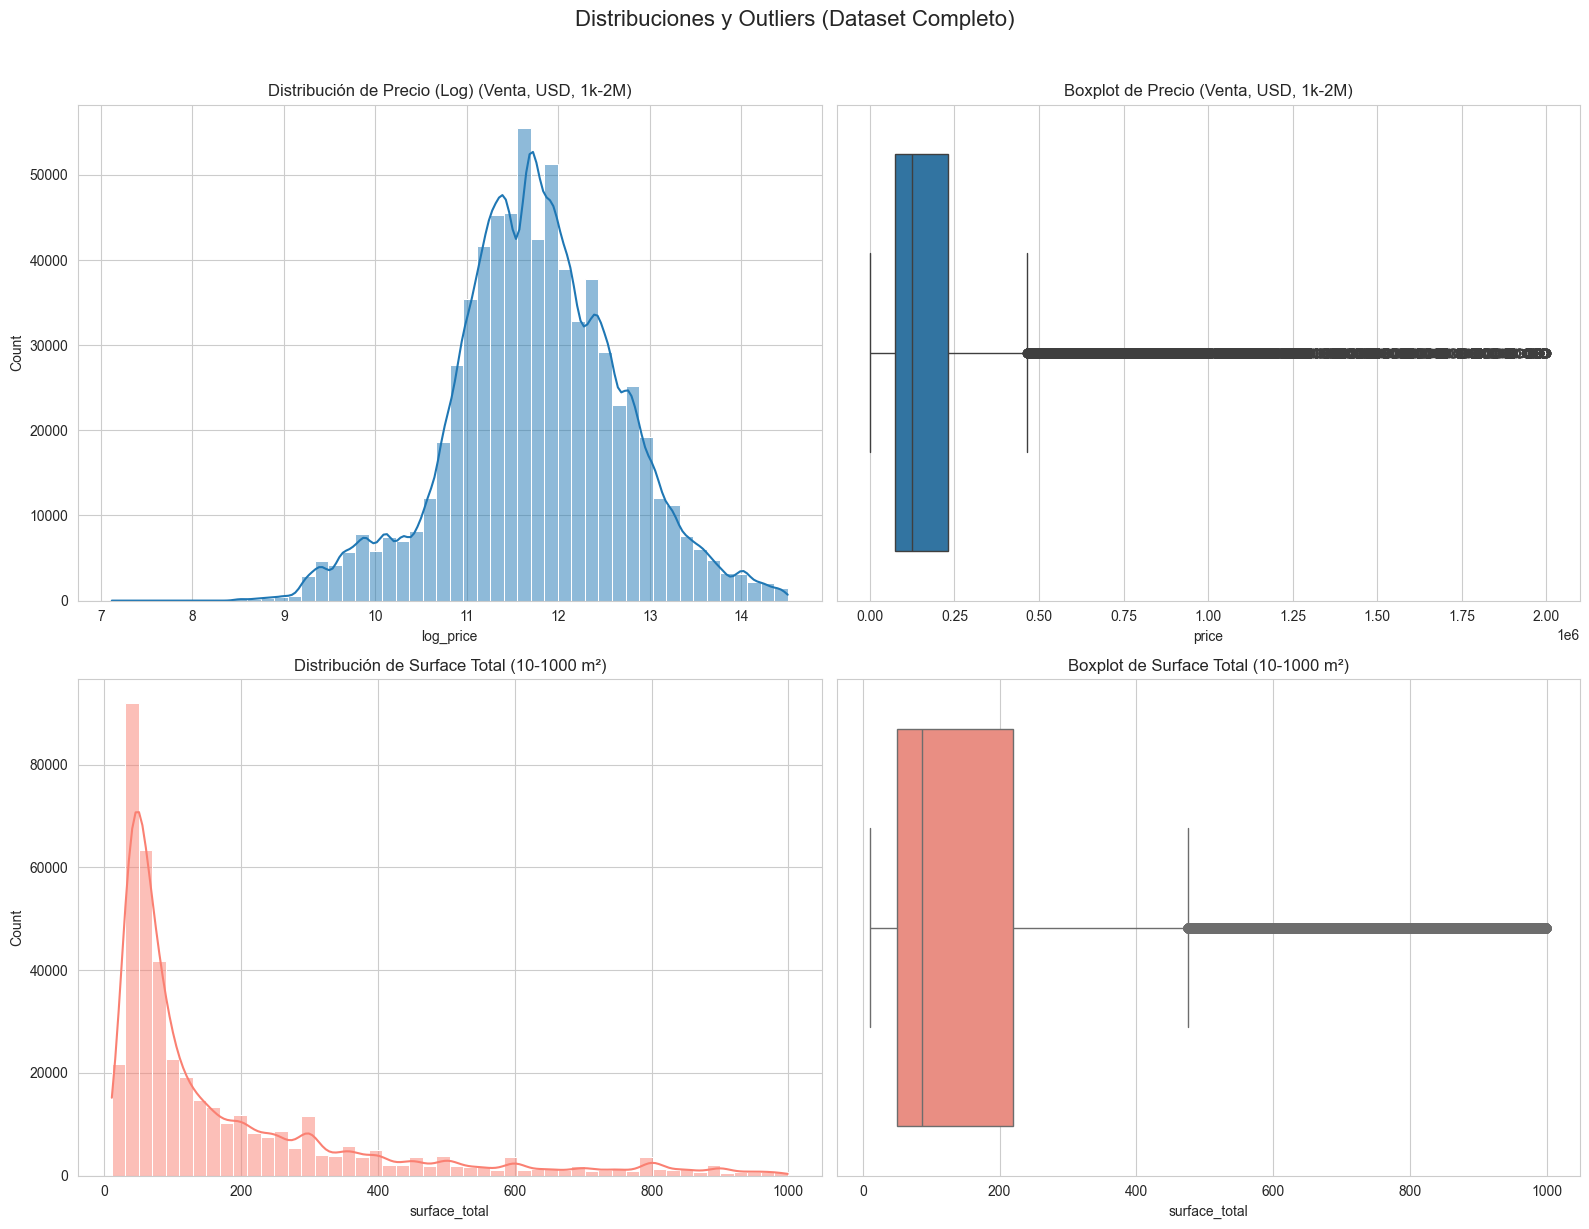

C:\Users\Goku\AppData\Local\Temp\ipykernel_13272\540961080.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_l2, y='l2', x='count', ax=axes[0], palette='viridis')
C:\Users\Goku\AppData\Local\Temp\ipykernel_13272\540961080.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_prop, y='property_type', x='count', ax=axes[1], palette='plasma')
C:\Users\Goku\AppData\Local\Temp\ipykernel_13272\540961080.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_op, y='operation_type', x='count', ax=axes[2], palette='ocean')


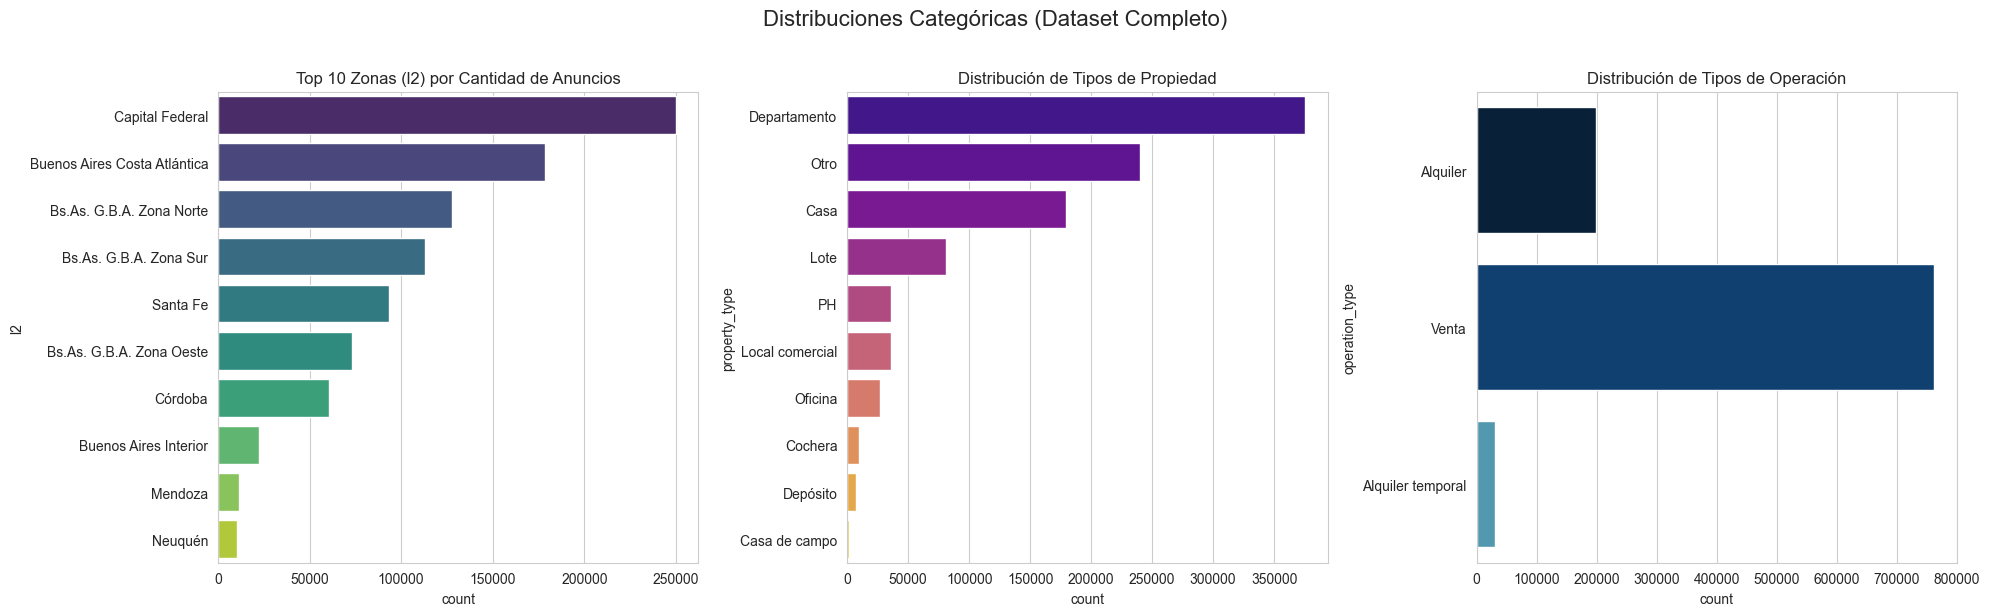

In [3]:
#
# EDA Dataset Completo ---
#
##
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import duckdb
from IPython.display import display, HTML

# Conectar a la base de datos 
try:
    con
except NameError:
    con = duckdb.connect()

parquet_file = "app/data/artifacts/parquet/entrenamiento.parquet"

display(HTML("<h2>EDA 1: Análisis del Dataset Completo </h2>"))
sns.set_style("whitegrid")

#  Análisis de Variables Numéricas Clave ---
display(HTML("<h3>1.1 Análisis de Variables Numéricas (Precio, Superficie)</h3>"))
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Distribuciones y Outliers (Dataset Completo)", fontsize=16, y=1.02)

# Histograma de Precio (Log-Transformado)
query_price = f"""
    SELECT price 
    FROM parquet_scan('{parquet_file}') 
    WHERE price > 1000 AND price < 2000000 AND currency = 'USD' AND operation_type = 'Venta'
"""
df_price = con.query(query_price).df()
df_price['log_price'] = np.log1p(df_price['price'])
sns.histplot(df_price['log_price'], kde=True, ax=axes[0, 0], bins=50)
axes[0, 0].set_title("Distribución de Precio (Log) (Venta, USD, 1k-2M)")

#  Boxplot de Precio (para ver outliers)
sns.boxplot(x=df_price['price'], ax=axes[0, 1])
axes[0, 1].set_title("Boxplot de Precio (Venta, USD, 1k-2M)")

#  Histograma de Superficie Total (con clipping)
query_surface = f"""
    SELECT surface_total 
    FROM parquet_scan('{parquet_file}') 
    WHERE surface_total > 10 AND surface_total < 1000
"""
df_surface = con.query(query_surface).df()
sns.histplot(df_surface['surface_total'], kde=True, ax=axes[1, 0], bins=50, color='salmon')
axes[1, 0].set_title("Distribución de Surface Total (10-1000 m²)")

#  Boxplot de Superficie Total
sns.boxplot(x=df_surface['surface_total'], ax=axes[1, 1], color='salmon')
axes[1, 1].set_title("Boxplot de Surface Total (10-1000 m²)")

plt.tight_layout()
plt.show()

# . Análisis de Variables Categóricas 
display(HTML("<h3>1.2 Análisis de Variables Categóricas (Ubicación, Tipo)</h3>"))
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("Distribuciones Categóricas (Dataset Completo)", fontsize=16, y=1.02)

# Top 10 Provincias/Zonas (l2)
query_l2 = f"""
    SELECT l2, COUNT(*) as count 
    FROM parquet_scan('{parquet_file}') 
    WHERE l2 IS NOT NULL
    GROUP BY l2 
    ORDER BY count DESC 
    LIMIT 10
"""
df_l2 = con.query(query_l2).df()
sns.barplot(data=df_l2, y='l2', x='count', ax=axes[0], palette='viridis')
axes[0].set_title("Top 10 Zonas (l2) por Cantidad de Anuncios")

#  Tipos de Propiedad (property_type)
query_prop = f"""
    SELECT property_type, COUNT(*) as count 
    FROM parquet_scan('{parquet_file}') 
    WHERE property_type IS NOT NULL
    GROUP BY property_type 
    ORDER BY count DESC
"""
df_prop = con.query(query_prop).df()
sns.barplot(data=df_prop, y='property_type', x='count', ax=axes[1], palette='plasma')
axes[1].set_title("Distribución de Tipos de Propiedad")

# Tipos de Operación (operation_type)
query_op = f"""
    SELECT operation_type, COUNT(*) as count 
    FROM parquet_scan('{parquet_file}') 
    GROUP BY operation_type
"""
df_op = con.query(query_op).df()
sns.barplot(data=df_op, y='operation_type', x='count', ax=axes[2], palette='ocean')
axes[2].set_title("Distribución de Tipos de Operación")

plt.tight_layout()
plt.show()


#

#### El dataset se limita a un tamaño mas manejable con fin de agilizar el prototipado de la aplicacion.  Esta limitación es solo con fines prácticos y no se incluiría en el paso a producción


In [16]:
df = duckdb.query(
    """
    SELECT *
    FROM 'app/data/artifacts/parquet/entrenamiento.parquet'
    WHERE l2 = 'Capital Federal'
"""
).df()
con.close()

#### Descripcion de datos y limpieza

In [17]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249738 entries, 0 to 249737
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               249738 non-null  int64         
 1   ad_type          249738 non-null  object        
 2   start_date       249738 non-null  datetime64[us]
 3   end_date         249738 non-null  datetime64[us]
 4   created_on       249738 non-null  datetime64[us]
 5   lat              217583 non-null  float64       
 6   lon              217705 non-null  float64       
 7   l1               249738 non-null  object        
 8   l2               249738 non-null  object        
 9   l3               225456 non-null  object        
 10  l4               10091 non-null   object        
 11  l5               0 non-null       object        
 12  l6               0 non-null       object        
 13  rooms            171449 non-null  float64       
 14  bedrooms         122

In [18]:
# sacar vacios y duplicados
df_clean = df.dropna().drop_duplicates()

In [19]:
# profile del df solo de capital
def profile(df: pd.DataFrame):
    profile = pd.DataFrame(
        {
            "dtype": df.dtypes,
            "n_nulls": df.isnull().sum(),
            "n_unique": df.nunique(),
            "min": df.min(numeric_only=True),
            "Q1": df.quantile(0.25, numeric_only=True),
            "median": df.median(numeric_only=True),
            "mean": df.mean(numeric_only=True),
            "Q3": df.quantile(0.75, numeric_only=True),
            "max": df.max(numeric_only=True),
        }
    )
    return profile


profile_df = profile(df)
display(profile_df)

,dtype,n_nulls,n_unique,min,Q1,median,mean,Q3,max
ad_type,object,0,1,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms,float64,37245,18,1.000000,1.000000,1.000000,1.545119,2.000000,2.000000e+01
bedrooms,float64,127386,65,-2.000000,1.000000,2.000000,1.951525,3.000000,3.030000e+02
created_on,datetime64[us],0,346,NaN,NaN,NaN,NaN,NaN,NaN
currency,object,8291,2,NaN,NaN,NaN,NaN,NaN,NaN
description,object,0,156677,NaN,NaN,NaN,NaN,NaN,NaN
end_date,datetime64[us],0,448,NaN,NaN,NaN,NaN,NaN,NaN
id,int64,0,249738,5.000000,216169.000000,463253.500000,469234.024125,693799.000000,1.000000e+06
l1,object,0,1,NaN,NaN,NaN,NaN,NaN,NaN
l2,object,0,1,NaN,NaN,NaN,NaN,NaN,NaN


### EDA gráficos para analizar CABA

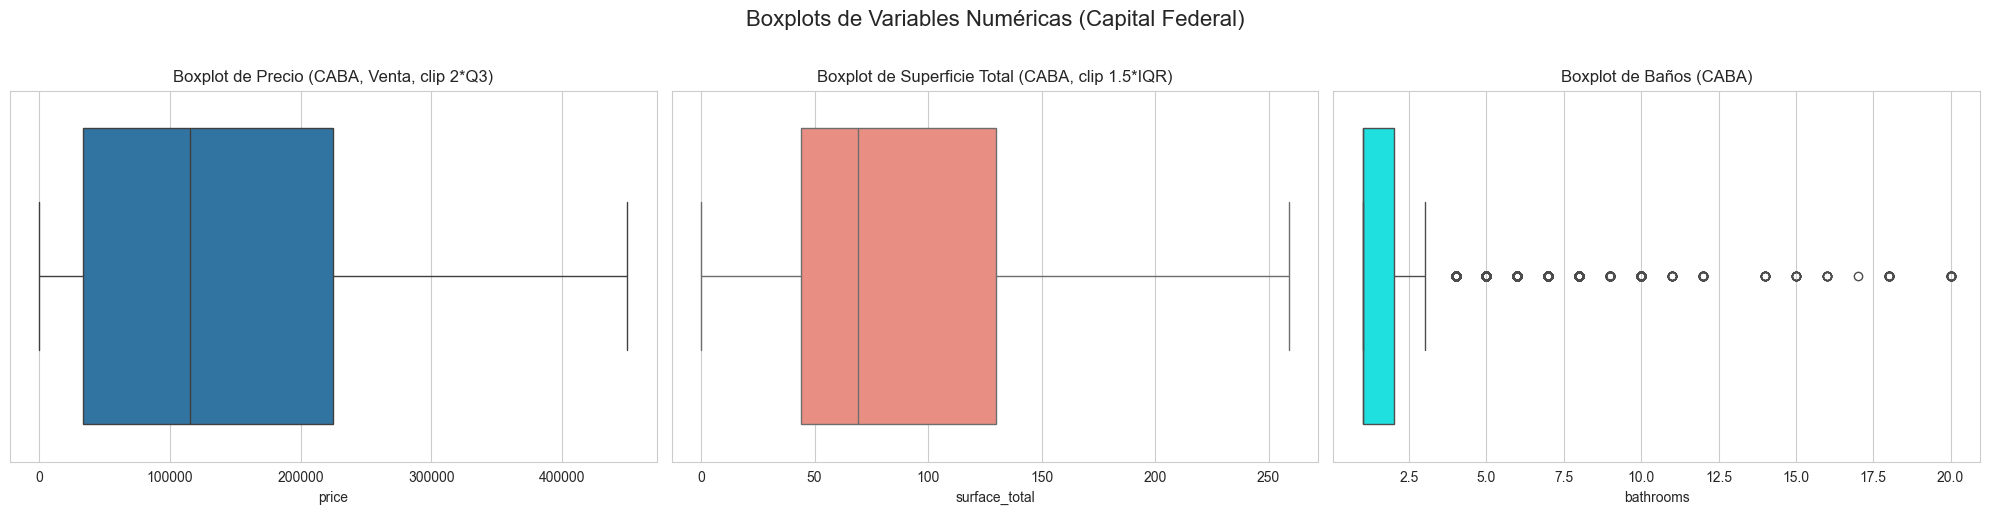

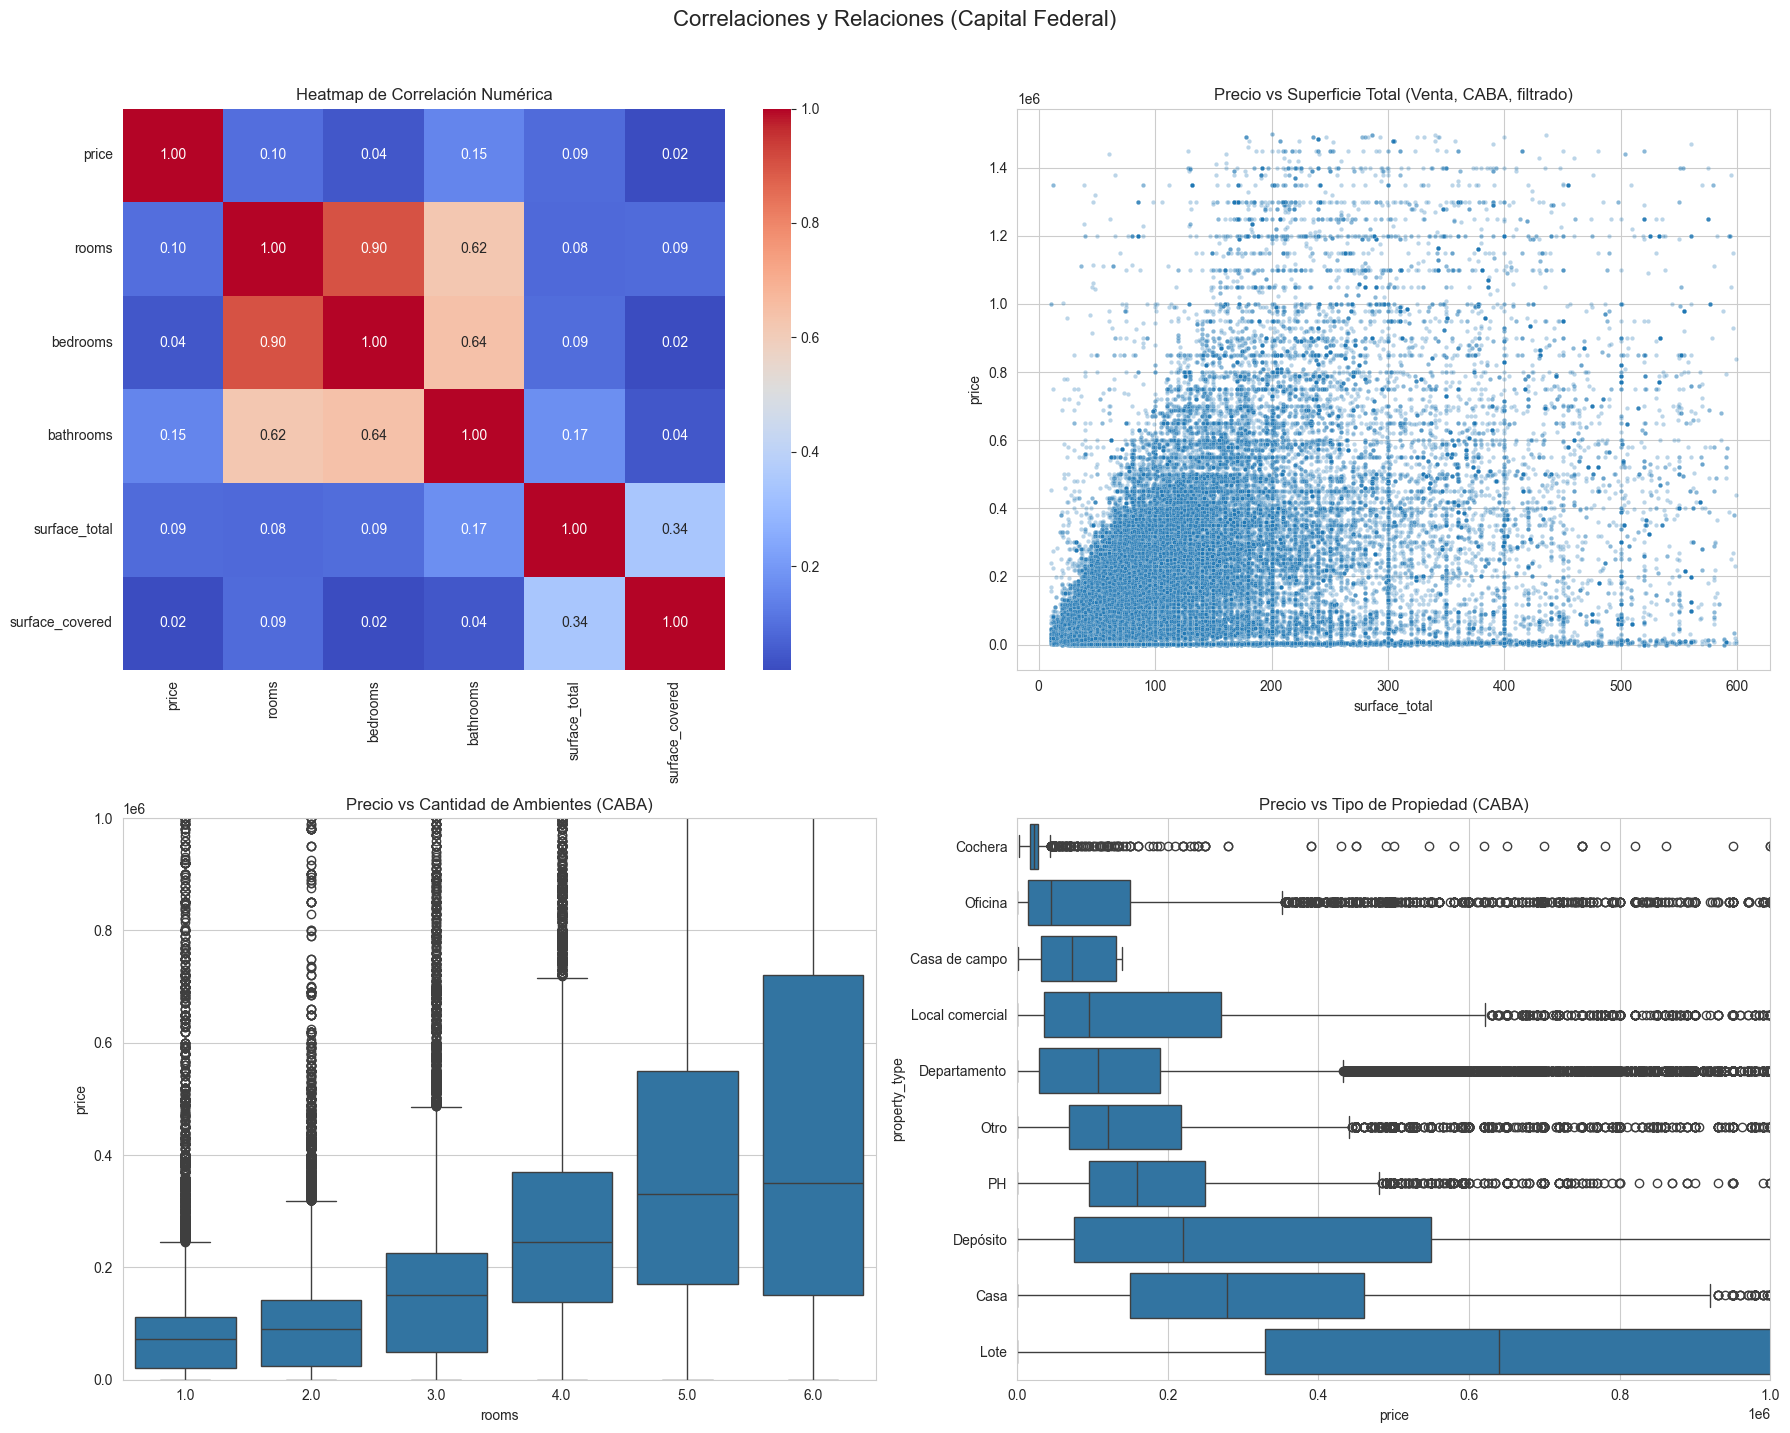

In [20]:


#
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, HTML

display(HTML("<h2>EDA 2: Análisis Detallado (Capital Federal)</h2>"))
sns.set_style("whitegrid")


#  Análisis de Outliers (Boxplots) ---
display(HTML("<h3>2.1 Análisis de Outliers en Capital Federal</h3>"))
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("Boxplots de Variables Numéricas (Capital Federal)", fontsize=16, y=1.02)

# 
q3_price = profile_df.loc['price', 'Q3']
q3_surface = profile_df.loc['surface_total', 'Q3']
iqr_surface = q3_surface - profile_df.loc['surface_total', 'Q1']

# Boxplot de Precio 
sns.boxplot(x=df['price'].clip(0, q3_price * 2), ax=axes[0]) # Clip 2 veces Q3
axes[0].set_title("Boxplot de Precio (CABA, Venta, clip 2*Q3)")

#  Boxplot de Superficie Total
sns.boxplot(x=df['surface_total'].clip(0, q3_surface + 1.5 * iqr_surface), ax=axes[1], color='salmon')
axes[1].set_title("Boxplot de Superficie Total (CABA, clip 1.5*IQR)")

# Boxplot de Baños
sns.boxplot(x=df['bathrooms'].dropna(), ax=axes[2], color='cyan')
axes[2].set_title("Boxplot de Baños (CABA)")

plt.tight_layout()
plt.show()

# Análisis Bivariado (Correlaciones) ---
display(HTML("<h3>2.2 Análisis Bivariado (Correlaciones)</h3>"))
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle("Correlaciones y Relaciones (Capital Federal)", fontsize=16, y=1.02)


numeric_features_caba = ['price', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
corr = df[numeric_features_caba].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[0, 0], fmt=".2f")
axes[0, 0].set_title("Heatmap de Correlación Numérica")

# Precio vs Superficie Total 
# 
df_scatter = df[(df['price'] < 1500000) & (df['surface_total'] < 600) & (df['surface_total'] > 10)]
sns.scatterplot(data=df_scatter, x='surface_total', y='price', ax=axes[0, 1], alpha=0.3, s=10)
axes[0, 1].set_title("Precio vs Superficie Total (Venta, CABA, filtrado)")

#  Precio vs Rooms (Boxplot)
sns.boxplot(data=df[df['rooms'] <= 6], x='rooms', y='price', ax=axes[1, 0])
axes[1, 0].set_title("Precio vs Cantidad de Ambientes (CABA)")
axes[1, 0].set_ylim(0, 1000000) # Limitar eje Y para mejor vista

#  Precio vs Tipo de Propiedad (Boxplot)
order_prop = df.groupby('property_type')['price'].median().sort_values().index
sns.boxplot(data=df, x='price', y='property_type', ax=axes[1, 1], order=order_prop)
axes[1, 1].set_title("Precio vs Tipo de Propiedad (CABA)")
axes[1, 1].set_xlim(0, 1000000) # Limitar eje X para mejor vista

plt.tight_layout()
plt.show()



In [21]:
import numpy as np


# manejo de outliers: no elimina filas, recorta los valores extremos al límite permitido
def clip_outliers(df, profile_df):
    df_clipped = df.copy()
    for col in df_clipped.select_dtypes(include=np.number).columns:
        Q1 = profile_df.loc[col, "Q1"]
        Q3 = profile_df.loc[col, "Q3"]
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped


df = clip_outliers(df, profile_df)

### Vista de resultados del trabajo con Outliers

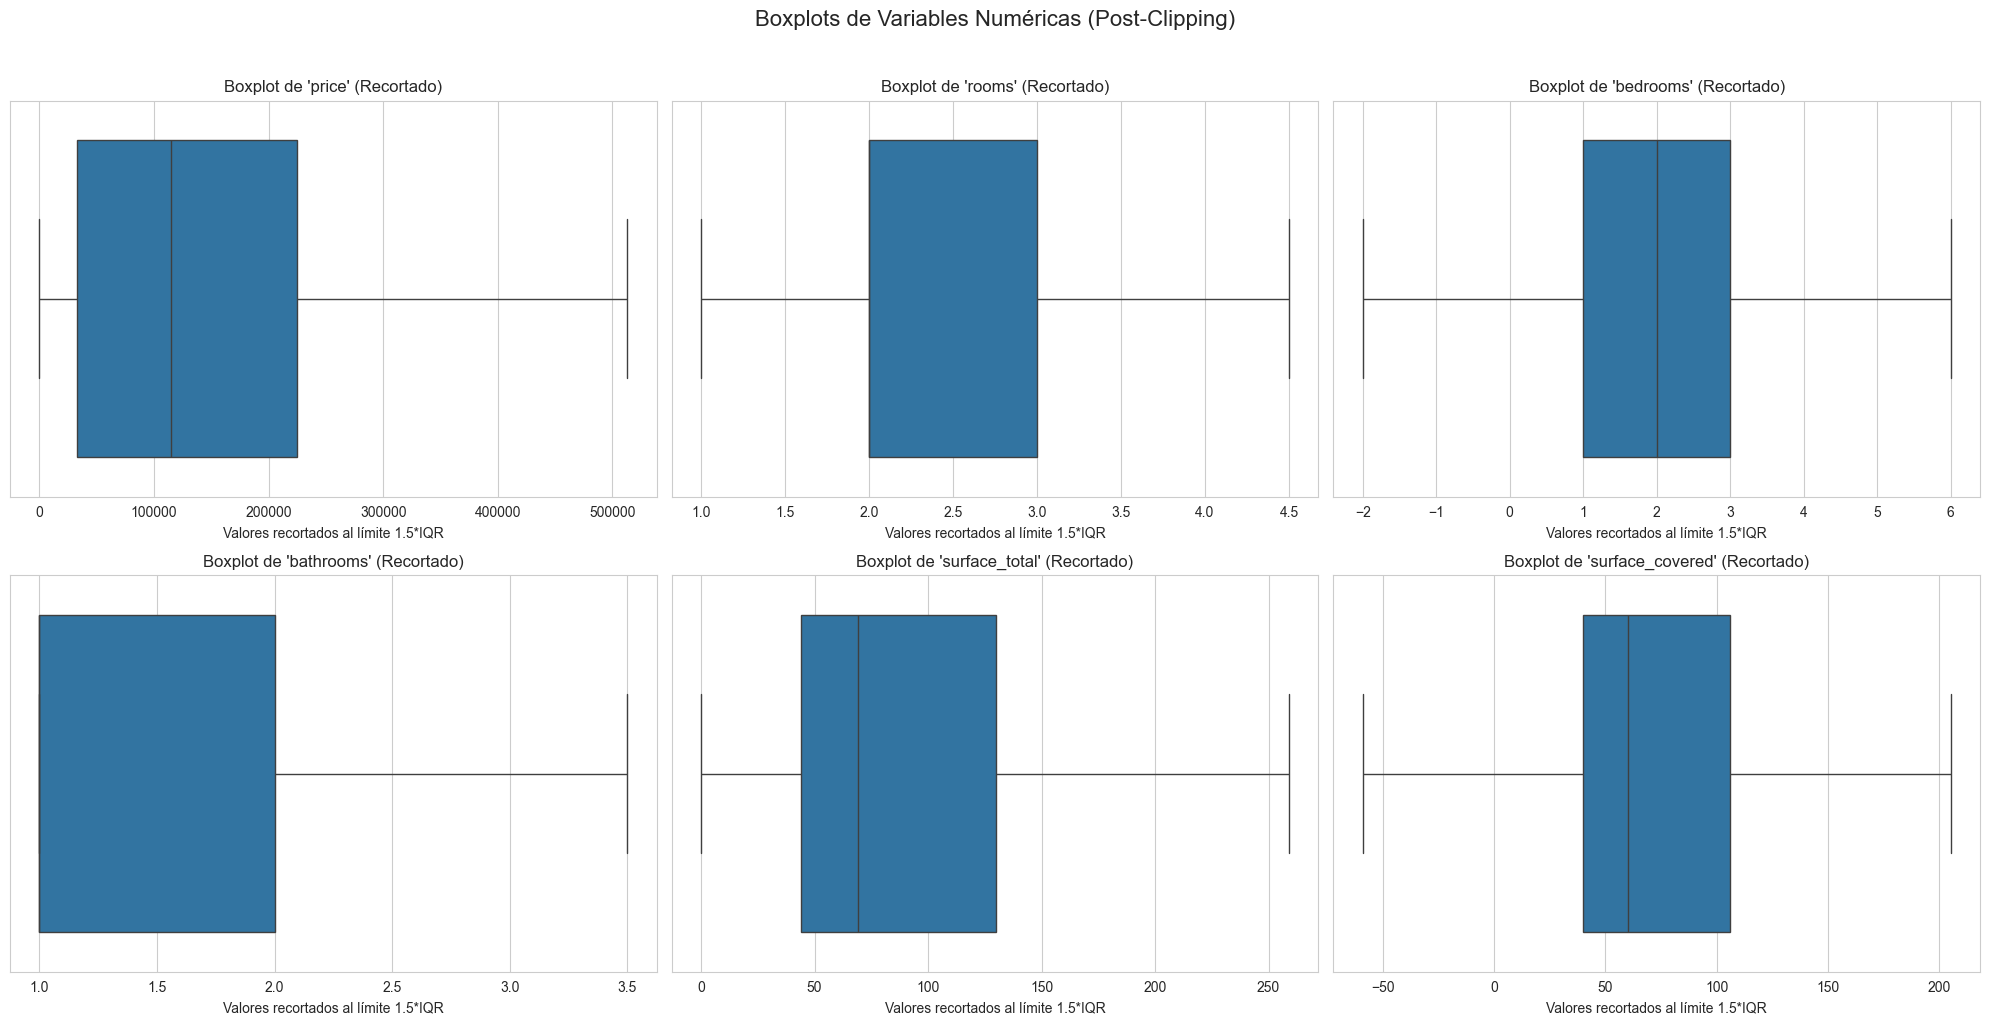

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

display(HTML("<h2>EDA 3: Verificación de Outliers Post-Clipping (Capital Federal)</h2>"))
sns.set_style("whitegrid")

cols_to_check = ['price', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

display(HTML(f"<p>Mostrando boxplots para las {len(cols_to_check)} variables numéricas clave <b>después</b> de aplicar <code>clip_outliers</code>.</p>"))

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("Boxplots de Variables Numéricas (Post-Clipping)", fontsize=16, y=1.02)

axes = axes.flatten()

for i, col in enumerate(cols_to_check):
    sns.boxplot(x=df[col].dropna(), ax=axes[i])
    axes[i].set_title(f"Boxplot de '{col}' (Recortado)")
    axes[i].set_xlabel("Valores recortados al límite 1.5*IQR")

plt.tight_layout()
plt.show()

In [ ]:
# contenido de columnas
for col in ["l1", "l2", "l3", "l4", "l5", "l6"]:
    print(f"\n Valores únicos en {col}:")
    print(df[col].dropna().unique())


 Valores únicos en l1:
['Argentina']

 Valores únicos en l2:
['Capital Federal']

 Valores únicos en l3:
['Colegiales' 'Almagro' 'Villa Urquiza' 'Boedo' 'San Telmo' 'Barrio Norte'
 'Villa Devoto' 'Palermo' 'Monserrat' 'Caballito' 'Balvanera'
 'Villa Ortuzar' 'Villa Crespo' 'Once' 'Saavedra' 'Recoleta'
 'Villa General Mitre' 'Villa del Parque' 'Belgrano' 'Mataderos'
 'Floresta' 'Coghlan' 'Flores' 'Velez Sarsfield' 'Parque Chacabuco'
 'Nuñez' 'Constitución' 'Las Cañitas' 'Villa Riachuelo' 'Puerto Madero'
 'Paternal' 'Congreso' 'Parque Centenario' 'Parque Patricios' 'Pompeya'
 'Villa Lugano' 'San Cristobal' 'Villa Real' 'San Nicolás' 'Boca'
 'Versalles' 'Villa Luro' 'Retiro' 'Chacarita' 'Barracas' 'Monte Castro'
 'Villa Pueyrredón' 'Parque Avellaneda' 'Liniers' 'Abasto' 'Tribunales'
 'Centro / Microcentro' 'Villa Santa Rita' 'Agronomía' 'Parque Chas'
 'Villa Soldati' 'Catalinas' 'Distrito Audiovisual']

 Valores únicos en l4:
['Palermo Viejo' 'Palermo Hollywood' 'Palermo Soho' 'Palermo C

In [ ]:
# sacar columnas innecesarias por estar vacias o ser irrelevantes
df = df.drop(
    columns=["title", "description", "ad_type", "id", "l1", "l2", "l4", "l5", "l6"]
)
df.head()

,start_date,end_date,created_on,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,currency,price_period,property_type,operation_type,price
0,2019-11-29,9999-12-31,2019-11-29,-58.442399,-34.573623,Colegiales,3.0,2.0,2.0,NaN,NaN,USD,None,Departamento,Venta,259000.0
1,2020-06-05,2020-06-08,2020-06-05,-58.430493,-34.606620,Almagro,3.0,2.0,2.0,77.0,67.0,USD,None,Departamento,Venta,235500.0
2,2020-07-01,9999-12-31,2020-07-01,-58.491760,-34.574123,Villa Urquiza,2.0,NaN,1.0,60.0,55.0,USD,None,Departamento,Venta,175000.0
3,2019-08-17,9999-12-31,2019-08-17,-58.420737,-34.631770,Boedo,2.0,1.0,1.0,74.0,47.0,USD,None,PH,Venta,140000.0
4,2019-08-05,2019-08-31,2019-08-05,-58.429983,-34.607225,Almagro,3.0,2.0,1.0,66.0,64.0,USD,None,Departamento,Venta,173000.0


In [ ]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249738 entries, 0 to 249737
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   start_date       249738 non-null  datetime64[us]
 1   end_date         249738 non-null  datetime64[us]
 2   created_on       249738 non-null  datetime64[us]
 3   lat              217583 non-null  float64       
 4   lon              217705 non-null  float64       
 5   l3               225456 non-null  object        
 6   rooms            171449 non-null  float64       
 7   bedrooms         122352 non-null  float64       
 8   bathrooms        212493 non-null  float64       
 9   surface_total    171780 non-null  float64       
 10  surface_covered  165345 non-null  float64       
 11  currency         241447 non-null  object        
 12  price_period     99785 non-null   object        
 13  property_type    249738 non-null  object        
 14  operation_type   249

#### Guardado de datos limpios en base de datos

In [ ]:
# Guardar datos limpios en DuckDB

con = duckdb.connect("app/data/DB/entrenamiento.duckdb")

# Registrar el DataFrame como tabla temporal
con.register("df_temp", df)

# guarda datos limpios en la base de datos duckdb
con.execute(
    """
    CREATE TABLE IF NOT EXISTS datos_clean AS 
    SELECT * FROM df_temp
"""
)

In [ ]:
tables = con.execute("SHOW TABLES").fetchall()
print(tables)

[('datos_clean',), ('datos_raw',), ('df_temp',), ('metricas',)]


#### Elección de features

In [ ]:
import json

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import TransformedTargetRegressor
import joblib
import os
import matplotlib.pyplot as plt


# --- feature engineering ---


def clean_temporal_columns(df, date_cols, placeholder="9999-12-31"):
    """
    Limpia columnas de fecha
    - Reemplaza valores ficticios  '9999-12-31' por pd.NA
    - Convierte a datetime con coerción de errores
    """
    for col in date_cols:
        if col in df.columns:
            # Detecta si el placeholder está presente
            if df[col].astype(str).str.contains(placeholder).any():
                df[col] = df[col].replace(placeholder, pd.NA)
            # Convierte a datetime
            df[col] = pd.to_datetime(df[col], errors="coerce")
    return df


# crea days active: end_date - start_date, y  days since created
# Si end_date es NA,se considera days_active como NaN
df["days_active"] = (df["end_date"] - df["start_date"]).dt.days.astype(float)
df["created_age_days"] = (pd.Timestamp.today() - df["created_on"]).dt.days.astype(float)

In [ ]:
# eleccion de features sin incluir columna target price
numeric_feats = [
    "lon",
    "lat",
    "rooms",
    "bedrooms",
    "bathrooms",
    "surface_total",
    "surface_covered",
    "days_active",
    "created_age_days",
]
categorical_feats = [
    "l3",
    "currency",
    "price_period",
    "property_type",
    "operation_type",
]

df = df.dropna(subset=["price"])  # saca las filas que tengan NA en price
X = df[numeric_feats + categorical_feats].copy()
y = df["price"].values  # saca los valores de la columna target

### Entrenamiento  y generación de artefactos 

In [ ]:
from dvclive import Live
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
import os

#  División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#  Preprocesamiento para Modelo A (RandomForest)
num_transform_rf = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("robust_scaler", RobustScaler()),
    ]
)

cat_transform = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preproc_rf = ColumnTransformer(
    [
        ("num", num_transform_rf, numeric_feats),
        ("cat", cat_transform, categorical_feats),
    ]
)

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=4,
    n_jobs=-1,
    random_state=42,
)

model_rf = Pipeline(
    [
        ("preproc", preproc_rf),
        (
            "est",
            TransformedTargetRegressor(
                regressor=rf, func=np.log1p, inverse_func=np.expm1
            ),
        ),
    ]
)

#  Preprocesamiento para Modelo B (GradientBoosting)
num_transform_gb = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

preproc_gb = ColumnTransformer(
    [
        ("num", num_transform_gb, numeric_feats),
        ("cat", cat_transform, categorical_feats),
    ]
)

model_gb = Pipeline(
    [
        ("preprocessor", preproc_gb),
        (
            "model",
            GradientBoostingRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=3,
                subsample=0.8,
                random_state=42,
            ),
        ),
    ]
)

#  Entrenamiento y logging con DVCLive
live = Live("app/data/metrics", save_dvc_exp=True)
live.log_params(
    {
        "split_test_size": 0.2,
        "rf_n_estimators": 100,
        "rf_min_samples_split": 4,
        "rf_scaler": "RobustScaler",
        "gb_n_estimators": 200,
        "gb_learning_rate": 0.05,
        "gb_max_depth": 3,
        "gb_subsample": 0.8,
        "numeric_features": numeric_feats,
        "categorical_features": categorical_feats,
    }
)
# Force DVCLive to persist params.yaml
live.next_step()

print("Entrenando modelos...")
model_rf.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
print("Entrenamiento completo")

#  Evaluación


def evaluate(model, X_te, y_te, name="model"):
    y_pred = model.predict(X_te)
    rmse = mean_squared_error(y_te, y_pred) ** 0.5
    mae = mean_absolute_error(y_te, y_pred)
    r2 = r2_score(y_te, y_pred)
    print(f"--- {name} ---")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2: {r2:.4f}")
    return {"rmse": float(rmse), "mae": float(mae), "r2": float(r2)}


metrics_rf = evaluate(model_rf, X_test, y_test, name="RandomForest")
metrics_gb = evaluate(model_gb, X_test, y_test, name="GradientBoosting")

#  Logging con DVCLive
live = Live("app/data/metrics", resume=True)
live.log_metric("rf_rmse", metrics_rf["rmse"])
live.log_metric("rf_mae", metrics_rf["mae"])
live.log_metric("rf_r2", metrics_rf["r2"])

live.log_metric("gb_rmse", metrics_gb["rmse"])
live.log_metric("gb_mae", metrics_gb["mae"])
live.log_metric("gb_r2", metrics_gb["r2"])
live.next_step()

# Guardar modelos .joblib
os.makedirs("app/data/artifacts/housing_models", exist_ok=True)
joblib.dump(model_rf, "app/data/artifacts/housing_models/random_forest.joblib")
joblib.dump(model_gb, "app/data/artifacts/housing_models/gradient_boosting.joblib")

# Manifiesto
manifest = {
    "models": [
        {"name": "RandomForest", "metrics": metrics_rf},
        {"name": "GradientBoosting", "metrics": metrics_gb},
    ]
}
with open("app/data/artifacts/housing_models/manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)

Entrenando modelos...
Entrenamiento completado.
--- RandomForest ---
RMSE: 49205.83
MAE: 21751.24
R2: 0.8962
--- GradientBoosting ---
RMSE: 69314.11
MAE: 43725.94
R2: 0.7940


#### Guardar métricas y parámetros en la base experimentos.duckdb

In [ ]:
# Guardar métricas y parámetros en DuckDB
import yaml
from datetime import datetime

# Guardar métricas y parámetros en DuckDB
DB_DIR = "app/data/DB"
DB_PATH = os.path.join(DB_DIR, "experimento.duckdb")  
os.makedirs(DB_DIR, exist_ok=True)  # crea carpeta si no existe

#  crea la base si no existe
con = duckdb.connect(DB_PATH)

# Cargar parámetros desde YAML
params_path = "app/data/metrics/params.yaml"
with open(params_path, "r") as f:
    params = yaml.safe_load(f)


con.execute(
    """
CREATE TABLE IF NOT EXISTS metricas (
    fecha TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    experimento TEXT,
    modelo TEXT,
    rmse DOUBLE,
    mae DOUBLE,
    r2 DOUBLE,
    rf_n_estimators INTEGER,
    rf_min_samples_split INTEGER,
    gb_n_estimators INTEGER,
    gb_learning_rate DOUBLE,
    gb_max_depth INTEGER,
    gb_subsample DOUBLE,
    test_size DOUBLE
)
"""
)

# Nombre del experimento 
exp_name = "exp_" + datetime.now().strftime("%Y%m%d_%H%M%S")

#  Obtener parámetros con defaults 
rf_n_estimators = params.get("rf_n_estimators")
rf_min_samples_split = params.get("rf_min_samples_split")
gb_n_estimators = params.get("gb_n_estimators")
gb_learning_rate = params.get("gb_learning_rate")
gb_max_depth = params.get("gb_max_depth")
gb_subsample = params.get("gb_subsample")
test_size = params.get("split_test_size", 0.2)

#  Insertar métricas de RandomForest
con.execute(
    """
INSERT INTO metricas VALUES (
    CURRENT_TIMESTAMP, ?, 'RandomForest', ?, ?, ?, ?, ?, ?, ?, ?, ?, ?
)
""",
    [
        exp_name,
        metrics_rf["rmse"],
        metrics_rf["mae"],
        metrics_rf["r2"],
        rf_n_estimators,
        rf_min_samples_split,
        None,
        None,
        None,
        None,
        test_size,
    ],
)

#  Insertar métricas de GradientBoosting 
con.execute(
    """
INSERT INTO metricas VALUES (
    CURRENT_TIMESTAMP, ?, 'GradientBoosting', ?, ?, ?, ?, ?, ?, ?, ?, ?, ?
)
""",
    [
        exp_name,
        metrics_gb["rmse"],
        metrics_gb["mae"],
        metrics_gb["r2"],
        None,
        None,
        gb_n_estimators,
        gb_learning_rate,
        gb_max_depth,
        gb_subsample,
        test_size,
    ],
)

con.close()
print(f" Métricas y parámetros guardados en: {DB_PATH}")


 Métricas y parámetros guardados correctamente en: app/data/DB\experimento.duckdb


In [ ]:
# chequear guardado de metricas
con = duckdb.connect(DB_PATH)
df = con.execute("SELECT * FROM metricas ORDER BY fecha DESC").df()
df


,fecha,experimento,modelo,rmse,mae,r2,rf_n_estimators,rf_min_samples_split,gb_n_estimators,gb_learning_rate,gb_max_depth,gb_subsample,test_size
0,2025-11-12 02:13:39.771333,exp_20251112_021339,GradientBoosting,69314.105732,43725.940112,0.793973,<NA>,<NA>,100,0.05,3,0.8,0.2
1,2025-11-12 02:13:39.762505,exp_20251112_021339,RandomForest,49205.825072,21751.243063,0.896172,100,4,<NA>,NaN,<NA>,NaN,0.2
2,2025-11-12 01:54:30.549236,exp_20251112_015430,GradientBoosting,69314.105732,43725.940112,0.793973,<NA>,<NA>,100,0.05,3,0.8,0.2
3,2025-11-12 01:54:30.538697,exp_20251112_015430,RandomForest,49205.825072,21751.243063,0.896172,100,4,<NA>,NaN,<NA>,NaN,0.2


#### Chequeo de importancia de las columnas para que en la API las columnas importantes sean obligatorias:


Importancia de features en modelo A (RandomForest):
base_feature
operation    0.413608
currency     0.347680
surface      0.107221
property     0.029390
bathrooms    0.023012
lon          0.020171
lat          0.016011
l3           0.014984
created      0.009474
days         0.008786
Name: importance, dtype: float64

Importancia de features en modelo B (GradientBoosting):
base_feature
operation    0.386520
surface      0.342081
bathrooms    0.111103
currency     0.056938
property     0.050231
l3           0.022863
lon          0.021554
rooms        0.005041
lat          0.001915
days         0.001000
Name: importance, dtype: float64


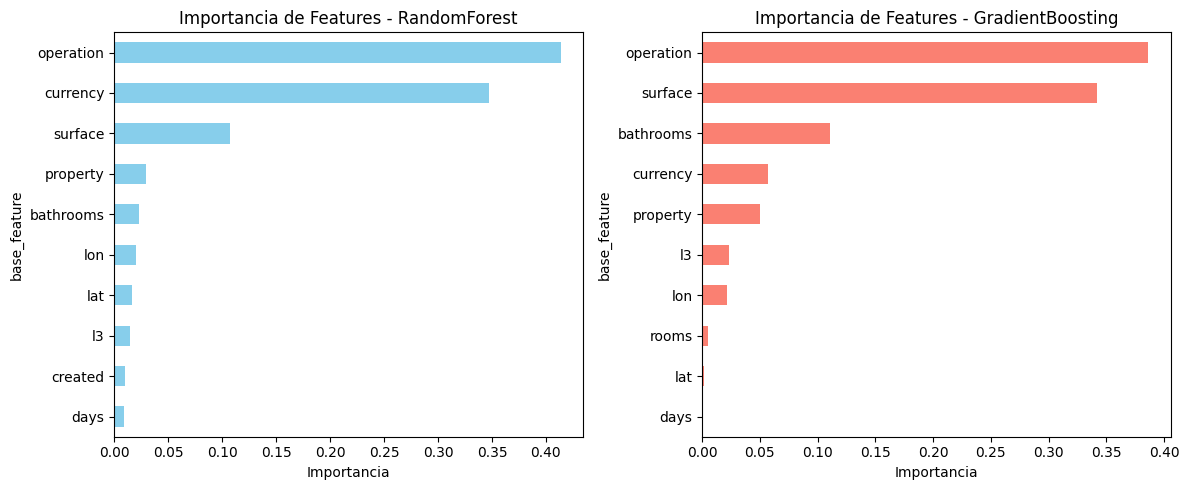

In [ ]:
# Recupera nombres de features por separado
feature_names_rf = model_rf.named_steps["preproc"].get_feature_names_out()
feature_names_gb = model_gb.named_steps["preprocessor"].get_feature_names_out()

# Extraer los estimadores internos
rf_estimator = model_rf.named_steps["est"].regressor_
gb_estimator = model_gb.named_steps["model"]

# DataFrames de importancia
rf_importances = pd.DataFrame(
    {
        "feature": feature_names_rf,
        "importance": rf_estimator.feature_importances_,
    }
).sort_values("importance", ascending=False)

gb_importances = pd.DataFrame(
    {
        "feature": feature_names_gb,
        "importance": gb_estimator.feature_importances_,
    }
).sort_values("importance", ascending=False)

# Agrupar por feature base
rf_importances["base_feature"] = (
    rf_importances["feature"]
    .str.replace(r"^(num__|cat__)", "", regex=True)
    .str.split("_")
    .str[0]
)
gb_importances["base_feature"] = (
    gb_importances["feature"]
    .str.replace(r"^(num__|cat__)", "", regex=True)
    .str.split("_")
    .str[0]
)

rf_grouped = (
    rf_importances.groupby("base_feature")["importance"]
    .sum()
    .sort_values(ascending=False)
)
gb_grouped = (
    gb_importances.groupby("base_feature")["importance"]
    .sum()
    .sort_values(ascending=False)
)

print("\nImportancia de features en modelo A (RandomForest):")
print(rf_grouped.head(10))
print("\nImportancia de features en modelo B (GradientBoosting):")
print(gb_grouped.head(10))

# --- Gráficos ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
rf_grouped.head(10).plot(kind="barh", ax=axes[0], color="skyblue")
axes[0].invert_yaxis()
axes[0].set_title("Importancia de Features - RandomForest")
axes[0].set_xlabel("Importancia")

gb_grouped.head(10).plot(kind="barh", ax=axes[1], color="salmon")
axes[1].invert_yaxis()
axes[1].set_title("Importancia de Features - GradientBoosting")
axes[1].set_xlabel("Importancia")

plt.tight_layout()
plt.show()

 operation_type y currency son categórias binarias.
En modelos de árboles se particionan fácil, tienen bajo riesgo de overfitting, y ofrecen ganancias de información grandes en los primeros splits, (importancia alta). Una vez que el árbol separó “Venta” vs “Alquiler”, recién dentro de cada rama usa surface, bathrooms, etc. para ajustar el precio fino.
Eso reduce su importancia global, aunque sean relevantes dentro de cada segmento.

In [ ]:
# si se corrio experimento con ''dvc exp run'' ver metricas
!dvc metrics show

Path                           gb_mae       gb_r2    gb_rmse      rf_mae       rf_r2    rf_rmse      step
app\data\metrics\metrics.json  43725.94011  0.79397  69314.10573  21751.24306  0.89617  49205.82507  0


#### chequeo de los resultados del experimento en experimento.duckdb

In [2]:
import duckdb

# Conexión a la base
con = duckdb.connect("app/data/DB/experimento.duckdb")

# Consulta ordenada por fecha descendente
df = con.execute("SELECT * FROM metricas ORDER BY fecha DESC").df()

# Visualización
df

,fecha,experimento,modelo,rmse,mae,r2,rf_n_estimators,rf_min_samples_split,gb_n_estimators,gb_learning_rate,gb_max_depth,gb_subsample,test_size
0,2025-11-13 00:58:09.507732,exp_20251113_005809,GradientBoosting,82281.856188,54790.731984,0.747401,<NA>,<NA>,200,0.05,3,0.8,0.2
1,2025-11-13 00:58:09.500013,exp_20251113_005809,RandomForest,61412.676275,29148.245841,0.859285,100,4,<NA>,NaN,<NA>,NaN,0.2
2,2025-11-13 00:51:04.037438,exp_20251113_005104,GradientBoosting,82281.856188,54790.731984,0.747401,<NA>,<NA>,200,0.05,3,0.8,0.2
3,2025-11-13 00:51:04.030343,exp_20251113_005104,RandomForest,61412.676275,29148.245841,0.859285,100,4,<NA>,NaN,<NA>,NaN,0.2
4,2025-11-12 23:40:43.620408,exp_20251112_234043,GradientBoosting,82281.856188,54790.731984,0.747401,<NA>,<NA>,200,0.05,3,0.8,0.2
5,2025-11-12 23:40:43.615504,exp_20251112_234043,RandomForest,61412.676275,29148.245841,0.859285,100,4,<NA>,NaN,<NA>,NaN,0.2
6,2025-11-12 23:36:03.521694,exp_20251112_233603,GradientBoosting,82281.856188,54790.731984,0.747401,<NA>,<NA>,200,0.05,3,0.8,0.2
7,2025-11-12 23:36:03.514842,exp_20251112_233603,RandomForest,61412.676275,29148.245841,0.859285,100,4,<NA>,NaN,<NA>,NaN,0.2
8,2025-11-12 23:30:07.915472,exp_20251112_233007,GradientBoosting,82281.856188,54790.731984,0.747401,<NA>,<NA>,200,0.05,3,0.8,0.2
9,2025-11-12 23:30:07.901973,exp_20251112_233007,RandomForest,61412.676275,29148.245841,0.859285,100,4,<NA>,NaN,<NA>,NaN,0.2


###  CELDA DE PREDICCIÓN Y RESUMEN

In [ ]:

# Esta celda carga los modelos y métricas guardados para
# mostrar un resumen comparativo de parámetros, métricas y predicciones.

import joblib
import json
import pandas as pd
import numpy as np
import os
from IPython.display import display, HTML

# --- 1. Definir Rutas de Artefactos ---
MODELS_DIR = "app/data/artifacts/housing_models"
MANIFEST_PATH = os.path.join(MODELS_DIR, "manifest.json")
RF_MODEL_PATH = os.path.join(MODELS_DIR, "random_forest.joblib")
GB_MODEL_PATH = os.path.join(MODELS_DIR, "gradient_boosting.joblib")

# Configurar pandas para mejor visualización
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_colwidth', None)

print("Cargando artefactos desde 'app/data/artifacts/housing_models/'...")

try:
    # --- 2. Cargar Artefactos ---
    model_rf = joblib.load(RF_MODEL_PATH)
    model_gb = joblib.load(GB_MODEL_PATH)
    with open(MANIFEST_PATH, 'r') as f:
        manifest = json.load(f)
    print("Modelos y métricas cargados con éxito.\n")

    # --- 3. Crear 4 Departamentos de Ejemplo ---
    datos_ejemplo = [
        # (ID para unir después)
        {"id_ejemplo": 1, "lon": -58.4333, "lat": -34.5833, "l3": "Palermo", "rooms": 2.0, "bedrooms": 1.0, "bathrooms": 1.0, "surface_total": 45.0, "surface_covered": 40.0, "currency": "USD", "property_type": "Departamento", "operation_type": "Venta", "price_period": np.nan, "days_active": 30.0, "created_age_days": 35.0},
        {"id_ejemplo": 2, "lon": -58.42, "lat": -34.61, "l3": "Almagro", "rooms": 3.0, "bedrooms": 2.0, "bathrooms": 1.0, "surface_total": 70.0, "surface_covered": 65.0, "currency": "USD", "property_type": "Departamento", "operation_type": "Venta", "price_period": np.nan, "days_active": 150.0, "created_age_days": 150.0},
        {"id_ejemplo": 3, "lon": -58.4917, "lat": -34.5741, "l3": "Villa Urquiza", "rooms": 4.0, "bedrooms": 3.0, "bathrooms": 2.0, "surface_total": 120.0, "surface_covered": 90.0, "currency": "USD", "property_type": "PH", "operation_type": "Venta", "price_period": np.nan, "days_active": 10.0, "created_age_days": 12.0},
        {"id_ejemplo": 4, "lon": -58.4555, "lat": -34.5611, "l3": "Belgrano", "rooms": 1.0, "bedrooms": np.nan, "bathrooms": 1.0, "surface_total": 35.0, "surface_covered": 35.0, "currency": "USD", "property_type": "Departamento", "operation_type": "Venta", "price_period": np.nan, "days_active": np.nan, "created_age_days": np.nan}
    ]
    df_examples = pd.DataFrame(datos_ejemplo)

    # --- SECCIÓN 1. Comparativa de Parámetros ---
    display(HTML("<h2>1. Comparativa de Parámetros</h2>"))
    rf_params_data = model_rf.named_steps['est'].regressor_.get_params()
    gb_params_data = model_gb.named_steps['model'].get_params()
    
    params_data = {
        "RandomForest": {
            "n_estimators": rf_params_data['n_estimators'],
            "min_samples_split": rf_params_data['min_samples_split'],
            "max_depth": rf_params_data['max_depth'],
            "learning_rate": "N/A",
            "subsample": "N/A",
            "Preprocesamiento": "RobustScaler, Target Log-Transform"
        },
        "GradientBoosting": {
            "n_estimators": gb_params_data['n_estimators'],
            "min_samples_split": "N/A",
            "max_depth": gb_params_data['max_depth'],
            "learning_rate": gb_params_data['learning_rate'],
            "subsample": gb_params_data['subsample'],
            "Preprocesamiento": "StandardScaler"
        }
    }
    df_params = pd.DataFrame(params_data)
    df_params.index.name = "Parámetro"
    display(df_params)


    # --- SECCIÓN 2. Comparativa de Métricas de Evaluación ---
    display(HTML("<h2>2. Comparativa de Métricas de Evaluación</h2>"))
    rf_metrics = next(m['metrics'] for m in manifest['models'] if m['name'] == 'RandomForest')
    gb_metrics = next(m['metrics'] for m in manifest['models'] if m['name'] == 'GradientBoosting')
    
    metrics_data = {
        "RandomForest": {
            "R2": rf_metrics['r2'],
            "MAE (USD)": rf_metrics['mae'],
            "RMSE (USD)": rf_metrics['rmse']
        },
        "GradientBoosting": {
            "R2": gb_metrics['r2'],
            "MAE (USD)": gb_metrics['mae'],
            "RMSE (USD)": gb_metrics['rmse']
        }
    }
    df_metrics = pd.DataFrame(metrics_data)
    df_metrics.index.name = "Métrica"
    
    # Aplicar formato para que se vea bien
    display(df_metrics.style.format('{:,.4f}', subset=pd.IndexSlice['R2', :])
                          .format('{:,.2f}', subset=pd.IndexSlice[['MAE (USD)', 'RMSE (USD)'], :]))


    # --- SECCIÓN 3. Comparativa de Predicciones de Ejemplo ---
    display(HTML("<h2>3. Comparativa de Predicciones de Ejemplo</h2>"))
    
    # Realizar predicciones
    pred_rf = model_rf.predict(df_examples)
    pred_gb = model_gb.predict(df_examples)
    
    # Armar DataFrames de resultados
    df_pred_base = df_examples[['id_ejemplo', 'l3', 'property_type', 'rooms', 'surface_total']].set_index('id_ejemplo')
    df_pred_rf = pd.DataFrame(pred_rf, index=df_examples['id_ejemplo'], columns=['Precio_Predicho_RF'])
    df_pred_gb = pd.DataFrame(pred_gb, index=df_examples['id_ejemplo'], columns=['Precio_Predicho_GB'])
    
    # Unir todo
    df_pred_final = df_pred_base.join(df_pred_rf).join(df_pred_gb)
    display(df_pred_final)

    
except FileNotFoundError:
    print("\n*** ¡ERROR! ***")
    print("No se encontraron los archivos .joblib o manifest.json.")
    print("Por favor, asegúrate de ejecutar las celdas de entrenamiento")
    print("(IDs: 44a9ef0a y c25c3860) antes de ejecutar esta celda.")
except Exception as e:
    print(f"\n¡Ocurrió un error inesperado!: {e}")

Cargando artefactos desde 'app/data/artifacts/housing_models/'...
Modelos y métricas cargados con éxito.



,RandomForest,GradientBoosting
Parámetro,,
n_estimators,100,200
min_samples_split,4,N/A
max_depth,None,3
learning_rate,N/A,0.05
subsample,N/A,0.80
Preprocesamiento,"RobustScaler, Target Log-Transform",StandardScaler


,RandomForest,GradientBoosting
Métrica,,
R2,0.8962,0.7940
MAE (USD),"21,759.47","43,725.94"
RMSE (USD),"49,205.61","69,314.11"


,l3,property_type,rooms,surface_total,Precio_Predicho_RF,Precio_Predicho_GB
id_ejemplo,,,,,,
1,Palermo,Departamento,2.00,45.00,"82,342.88","125,209.08"
2,Almagro,Departamento,3.00,70.00,"78,757.89","146,095.62"
3,Villa Urquiza,PH,4.00,120.00,"133,563.40","204,611.94"
4,Belgrano,Departamento,1.00,35.00,"62,357.86","96,893.36"


### Gráficas del Negocio inmobiliario 

C:\Users\Goku\AppData\Local\Temp\ipykernel_13272\2056605462.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_10_count.index, x=top_10_count.values, ax=axes[0], palette='Blues_d')
C:\Users\Goku\AppData\Local\Temp\ipykernel_13272\2056605462.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_10_value.index, x=top_10_value.values, ax=axes[1], palette='Greens_d')


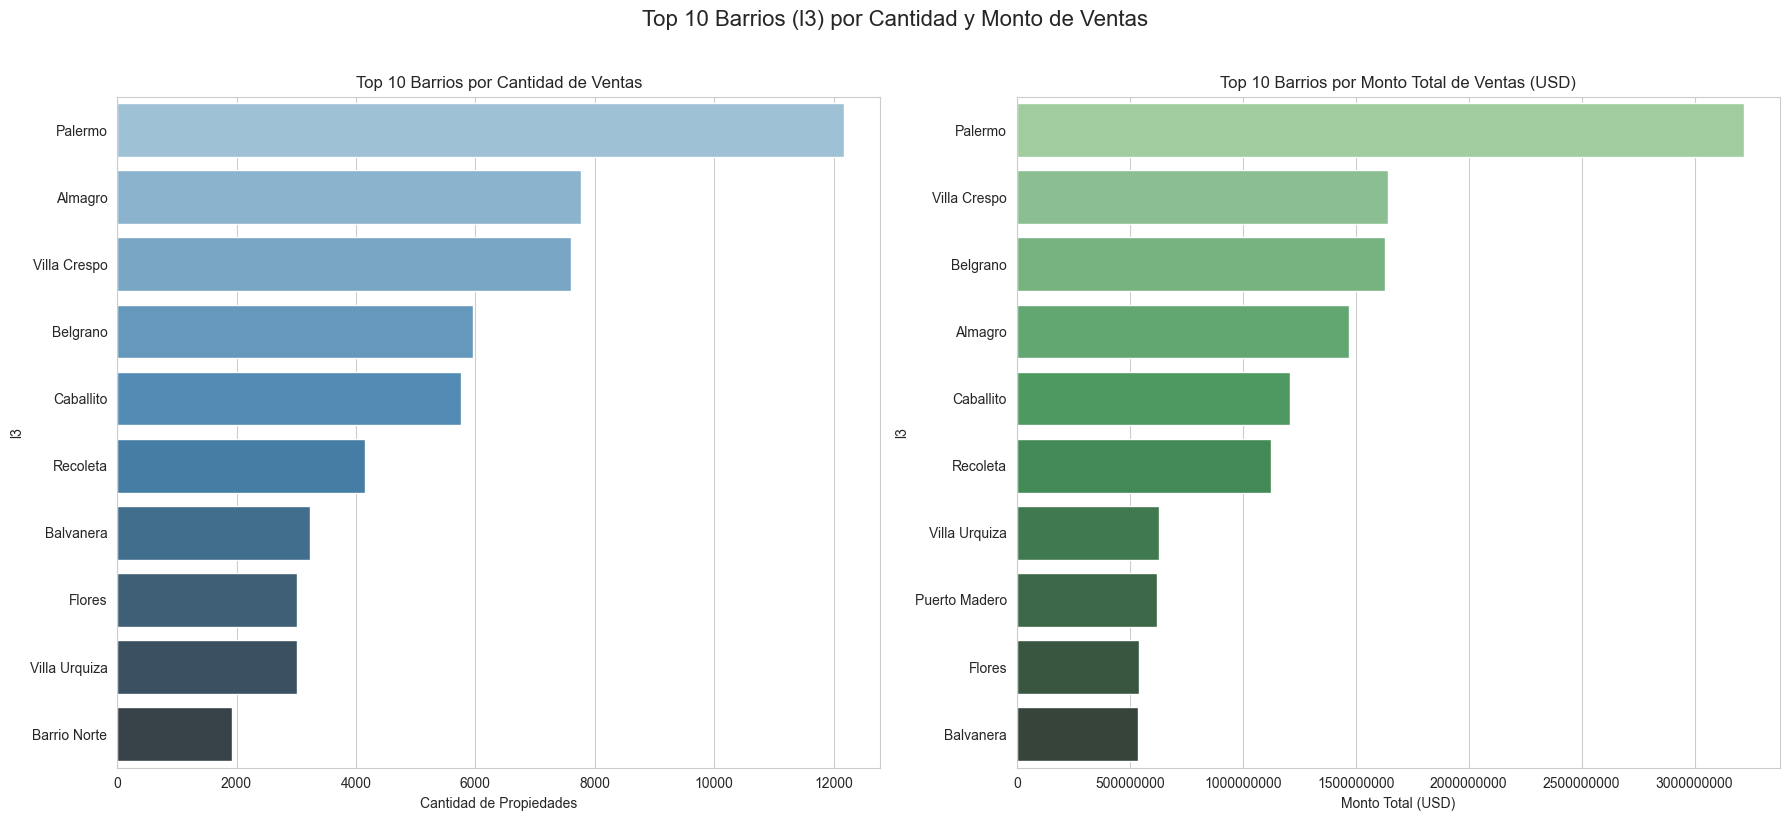

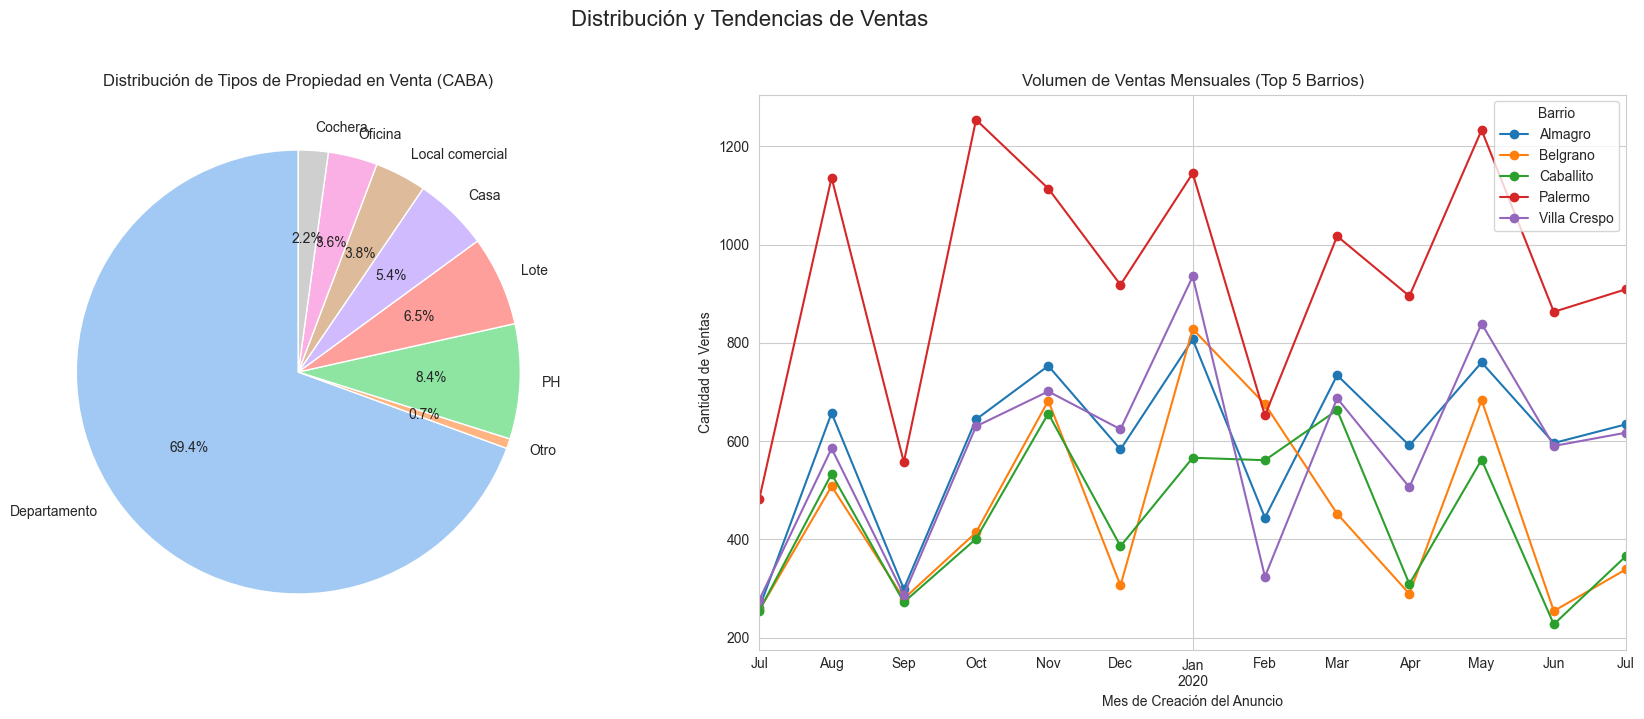

In [23]:
# --- Celda: Análisis de Negocio (Capital Federal) ---

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display, HTML

display(HTML("<h2>Análisis de Negocio (Capital Federal)</h2>"))
sns.set_style("whitegrid")

try:
    biz_df = df[
        (df['operation_type'] == 'Venta') &
        (df['currency'] == 'USD') &
        (df['price_period'].isnull())
    ].copy()
    
    display(HTML(f"<h3>Análisis basado en {len(biz_df)} ventas en USD en Capital Federal</h3>"))

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle("Top 10 Barrios (l3) por Cantidad y Monto de Ventas", fontsize=16, y=1.02)

    top_10_count = biz_df['l3'].value_counts().nlargest(10)
    sns.barplot(y=top_10_count.index, x=top_10_count.values, ax=axes[0], palette='Blues_d')
    axes[0].set_title("Top 10 Barrios por Cantidad de Ventas")
    axes[0].set_xlabel("Cantidad de Propiedades")

    top_10_value = biz_df.groupby('l3')['price'].sum().nlargest(10)
    sns.barplot(y=top_10_value.index, x=top_10_value.values, ax=axes[1], palette='Greens_d')
    axes[1].set_title("Top 10 Barrios por Monto Total de Ventas (USD)")
    axes[1].set_xlabel("Monto Total (USD)")
    axes[1].ticklabel_format(style='plain', axis='x') 

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle("Distribución y Tendencias de Ventas", fontsize=16, y=1.02)

    prop_counts = biz_df['property_type'].value_counts()
    prop_counts_main = prop_counts[prop_counts > prop_counts.sum() * 0.01] 
    prop_counts_main['Otro'] = prop_counts[prop_counts <= prop_counts.sum() * 0.01].sum()
    
    axes[0].pie(prop_counts_main.values, labels=prop_counts_main.index, autopct='%1.1f%%',
              startangle=90, colors=sns.color_palette('pastel'))
    axes[0].set_title("Distribución de Tipos de Propiedad en Venta (CABA)")

    biz_df['sale_month'] = pd.to_datetime(biz_df['created_on']).dt.to_period('M')
    
    top_5_barrios = top_10_count.index[:5].tolist()
    
    monthly_data = biz_df[biz_df['l3'].isin(top_5_barrios)]
    
    monthly_pivot = monthly_data.groupby(['sale_month', 'l3']).size().unstack()
    
    monthly_pivot.plot(kind='line', ax=axes[1], marker='o')
    axes[1].set_title("Volumen de Ventas Mensuales (Top 5 Barrios)")
    axes[1].set_xlabel("Mes de Creación del Anuncio")
    axes[1].set_ylabel("Cantidad de Ventas")
    axes[1].legend(title='Barrio')
    
    plt.tight_layout()
    plt.show()

except KeyError as e:
    display(HTML(f"<p style='color:red;'><b>Error:</b> No se encontró la columna {e}.</p>"))
except Exception as e:
    display(HTML(f"<p style='color:red;'><b>Ocurrió un error:</b> {e}</p>"))